# Load libraries & data

Last updated 041219

In [2]:
library(tidyverse)
library(magrittr)
library(data.table)
library(fuzzyjoin)
library(repr)
setwd("~/museum_data/")

Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

Read in specimen-trait-env data

In [4]:
specimens = read.delim("fulldata_processed_20181221_env.txt",sep="\t",header=FALSE,fill=FALSE,quote="") %>% 
set_colnames(c('ROW','ids','scientificname','sex','stateprovince','locality','decimallongitude','decimallatitude','preparations','lifestage','hastissue','dynamicproperties','habitat','year','total','tail','foot','ear','weight','body','decimallatitude.DAYMET','decimallongitude.DAYMET','elevation','tile','mean_annual_temp','mean_july_temp','mean_january_temp','mean_prec','mean_rad','ID','NA_NALCMS_LC_30m_LAEA_mmu12_urb05','decimallongitude.RASTER','decimallatitude.RASTER'))

How many samples have raster or daymet data?

In [5]:
specimens %>% filter(is.na(NA_NALCMS_LC_30m_LAEA_mmu12_urb05)) %>% nrow

[1] 185

# Analysis

Filter out "complicated" samples. These are samples that are in cropland, urban, barren, unknown, wetland or snow & ice areas

In [6]:
forest = c(1,2,3,4,5,6,14)
open = c(7,8,9,10,11,12,13)

core = specimens %>% filter(!NA_NALCMS_LC_30m_LAEA_mmu12_urb05 %in% c(0,15,16,17,18,19)) %>% filter(!is.na(NA_NALCMS_LC_30m_LAEA_mmu12_urb05))
nrow(core)

[1] 108689

Get some key body ratios, and add habitat class

In [7]:
core %<>%
    mutate(body = total-tail,
           tail_body = tail/body,
           foot_body = foot/body,
           ear_body = ear/body,
           hab_class = ifelse(NA_NALCMS_LC_30m_LAEA_mmu12_urb05 %in% forest,"forest","shrub/grassland"))
core %>% pull(hab_class) %>% head

[1] "forest" "forest" "forest" "forest" "forest" "forest"

Filter out juveniles, unlikely values

In [8]:
core %<>% 
    filter(tail_body < 1.5, tail_body > 0.4) %>% 
    filter(foot_body < 0.5, foot_body > 0) %>% 
    filter(ear_body < 0.5, ear_body > 0) %>% 
    filter(!grepl("subadult",lifestage,ignore.case=T),!grepl("juv",lifestage,ignore.case=T))
nrow(core)

[1] 21272

In [9]:
core %<>% drop_na(tail_body,foot_body,ear_body)

Get correlations between traits, over all individiduals and within each habitat class

In [52]:
f = core %>% filter(hab_class=="forest")
p = core %>% filter(hab_class=="shrub/grassland")

##
cor(core$tail_body,core$foot_body)
cor(f$tail_body,f$foot_body)
cor(p$tail_body,p$foot_body)

[1] 0.5432052

[1] 0.5203705

[1] 0.560535

In [83]:
cor(f$ear_body,f$foot_body)
cor(p$ear_body,p$foot_body)

[1] 0.5212223

[1] 0.5575442

## Plots & tests

In [14]:
plottable = melt(core %>% dplyr::select(ids,hab_class,tail_body,foot_body,ear_body), id=c("ids","hab_class"))
plottable %<>% set_colnames(c("ids","hab_class","morpho","ratio"))

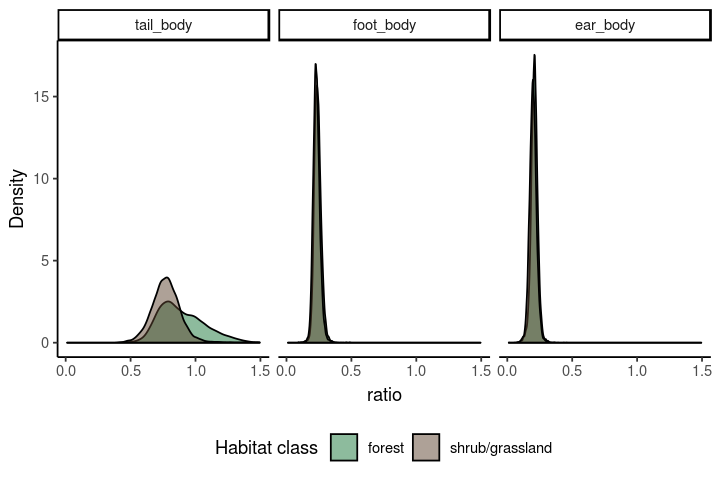

In [17]:
options(repr.plot.width=6,repr.plot.height=4)
ggplot(plottable) + 
    geom_density(aes(x=ratio,fill=hab_class),alpha=0.5) +
    facet_wrap(~morpho) +
    scale_fill_manual(name="Habitat class",values=c('#1C793D','#5F4531')) +
    theme_classic() + ylab("Density") + theme(legend.direction = "horizontal",legend.position="bottom")

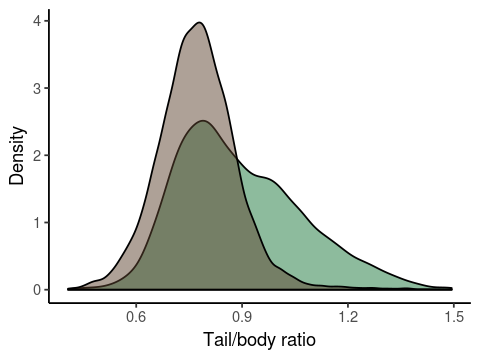

In [78]:
options(repr.plot.width=4,repr.plot.height=3)
ggplot(plottable %>% filter(morpho=="tail_body")) + 
    geom_density(aes(x=ratio,fill=hab_class),alpha=0.5) +
    scale_fill_manual(name="Habitat class",values=c('#1C793D','#5F4531')) +
    theme_classic() + theme(legend.position="none") + ylab("Density") + xlab("Tail/body ratio")

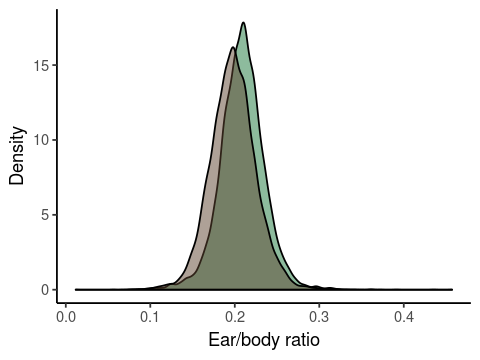

In [77]:
options(repr.plot.width=4,repr.plot.height=3)
ggplot(plottable %>% filter(morpho=="ear_body")) + 
    geom_density(aes(x=ratio,fill=hab_class),alpha=0.5) +
    scale_fill_manual(name="Habitat class",values=c('#1C793D','#5F4531')) +
    theme_classic() + theme(legend.position="none") + ylab("Density") + xlab("Ear/body ratio")

In [13]:
options(repr.plot.width=4,repr.plot.height=3)
ggplot(plottable %>% filter(morpho=="foot_body")) + 
    geom_density(aes(x=ratio,fill=hab_class),alpha=0.5) +
    scale_fill_manual(name="Habitat class",values=c('#1C793D','#5F4531')) +
    theme_classic() + theme(legend.position) + ylab("Density") + xlab("Foot/body ratio")

ERROR: Error in eval(lhs, parent, parent): object 'plottable' not found


T test

In [60]:
t.test(core$tail_body~core$hab_class)
t.test(core$foot_body~core$hab_class)
t.test(core$ear_body~core$hab_class)


	Welch Two Sample t-test

data:  core$tail_body by core$hab_class
t = 59.408, df = 19393, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1152528 0.1231175
sample estimates:
         mean in group forest mean in group shrub/grassland 
                    0.8937618                     0.7745767 



	Welch Two Sample t-test

data:  core$foot_body by core$hab_class
t = 24.927, df = 21182, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.008505281 0.009957036
sample estimates:
         mean in group forest mean in group shrub/grassland 
                    0.2409248                     0.2316936 



	Welch Two Sample t-test

data:  core$ear_body by core$hab_class
t = 28.859, df = 20842, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.009990141 0.011446045
sample estimates:
         mean in group forest mean in group shrub/grassland 
                    0.2087360                     0.1980179 


ANOVA to account for covariation

In [11]:
model = lm(tail_body ~ hab_class + decimallatitude + hab_class:decimallatitude + ear_body + foot_body + hab_class:foot_body + hab_class:ear_body + ear_body:foot_body +  hab_class:ear_body:foot_body,data = core)

library(car)

r = Anova(model,
      type = "II")
afss <- r$"Sum Sq"
print(cbind(r,PctExp=afss/sum(afss)*100))

                                   Sum Sq    Df     F value        Pr(>F)
hab_class                     26.15506056     1 1850.207942  0.000000e+00
decimallatitude               22.09207819     1 1562.792731  0.000000e+00
ear_body                       4.63498367     1  327.878560  9.807316e-73
foot_body                     68.45151133     1 4842.257183  0.000000e+00
hab_class:decimallatitude     10.85903589     1  768.167766 4.012409e-166
hab_class:foot_body            4.79099921     1  338.915093  4.216583e-75
hab_class:ear_body             2.74891521     1  194.458152  5.286506e-44
ear_body:foot_body             0.05677915     1    4.016555  4.506832e-02
hab_class:ear_body:foot_body   0.13674537     1    9.673362  1.872061e-03
Residuals                    300.56562030 21262          NA            NA
                                  PctExp
hab_class                     5.93769618
decimallatitude               5.01532191
ear_body                      1.05222944
foot_body             

In [12]:
model = lm(ear_body ~ hab_class + tail_body + foot_body + hab_class:foot_body + hab_class:tail_body + tail_body:foot_body +  hab_class:tail_body:foot_body,data = core)

library(car)

r = Anova(model,
      type = "II")
afss <- r$"Sum Sq"
print(cbind(r,PctExp=afss/sum(afss)*100))

                                    Sum Sq    Df      F value        Pr(>F)
hab_class                     5.931395e-02     1 1.195216e+02  9.544698e-28
tail_body                     1.884172e-01     1 3.796732e+02  7.894761e-84
foot_body                     2.228888e+00     1 4.491357e+03  0.000000e+00
hab_class:foot_body           9.568590e-03     1 1.928135e+01  1.133473e-05
hab_class:tail_body           2.446204e-01     1 4.929264e+02 5.544126e-108
tail_body:foot_body           8.686503e-08     1 1.750388e-04  9.894442e-01
hab_class:tail_body:foot_body 5.651948e-03     1 1.138905e+01  7.401025e-04
Residuals                     1.055251e+01 21264           NA            NA
                                    PctExp
hab_class                     4.463399e-01
tail_body                     1.417847e+00
foot_body                     1.677247e+01
hab_class:foot_body           7.200403e-02
hab_class:tail_body           1.840778e+00
tail_body:foot_body           6.536629e-07
hab_class:tail_

In [90]:
model = lm(foot_body ~ hab_class + tail_body + ear_body + hab_class:tail_body + hab_class:ear_body + tail_body:ear_body +  hab_class:tail_body:ear_body,data = core)

library(car)

r = Anova(model,
      type = "II")
afss <- r$"Sum Sq"
print(cbind(r,PctExp=afss/sum(afss)*100))

In [92]:
afss <- r$"Sum Sq"
print(cbind(r,PctExp=afss/sum(afss)*100))

                                  Sum Sq    Df     F value       Pr(>F)
hab_class                    0.042995051     1  100.547473 1.304395e-23
tail_body                    1.905906641     1 4457.119907 0.000000e+00
ear_body                     1.922463954     1 4495.840550 0.000000e+00
hab_class:tail_body          0.048171142     1  112.652190 2.991555e-26
hab_class:ear_body           0.005554241     1   12.989051 3.140332e-04
tail_body:ear_body           0.007123821     1   16.659644 4.488567e-05
hab_class:tail_body:ear_body 0.004054655     1    9.482146 2.077455e-03
Residuals                    9.092687576 21264          NA           NA
                                  PctExp
hab_class                     0.32999610
tail_body                    14.62823639
ear_body                     14.75531727
hab_class:tail_body           0.36972370
hab_class:ear_body            0.04262997
tail_body:ear_body            0.05467684
hab_class:tail_body:ear_body  0.03112034
Residuals               

## Maps

In [106]:
t = core %>% filter()

[1] -145.3072

[1] 19.17554

In [109]:
library(ggmap)
core_plot = core %>% filter(decimallongitude < 100)
bounds = make_bbox(lon=core_plot$decimallongitude,lat=core_plot$decimallatitude)
map = get_stamenmap(bounds, zoom = 5, maptype = "terrain-background",crop=FALSE)

72 tiles needed, this may take a while (try a smaller zoom).


In [120]:
t = core_plot %>% group_by(decimallongitude,decimallatitude,hab_class) %>% summarize(count=n())
max(t$count)

[1] 329

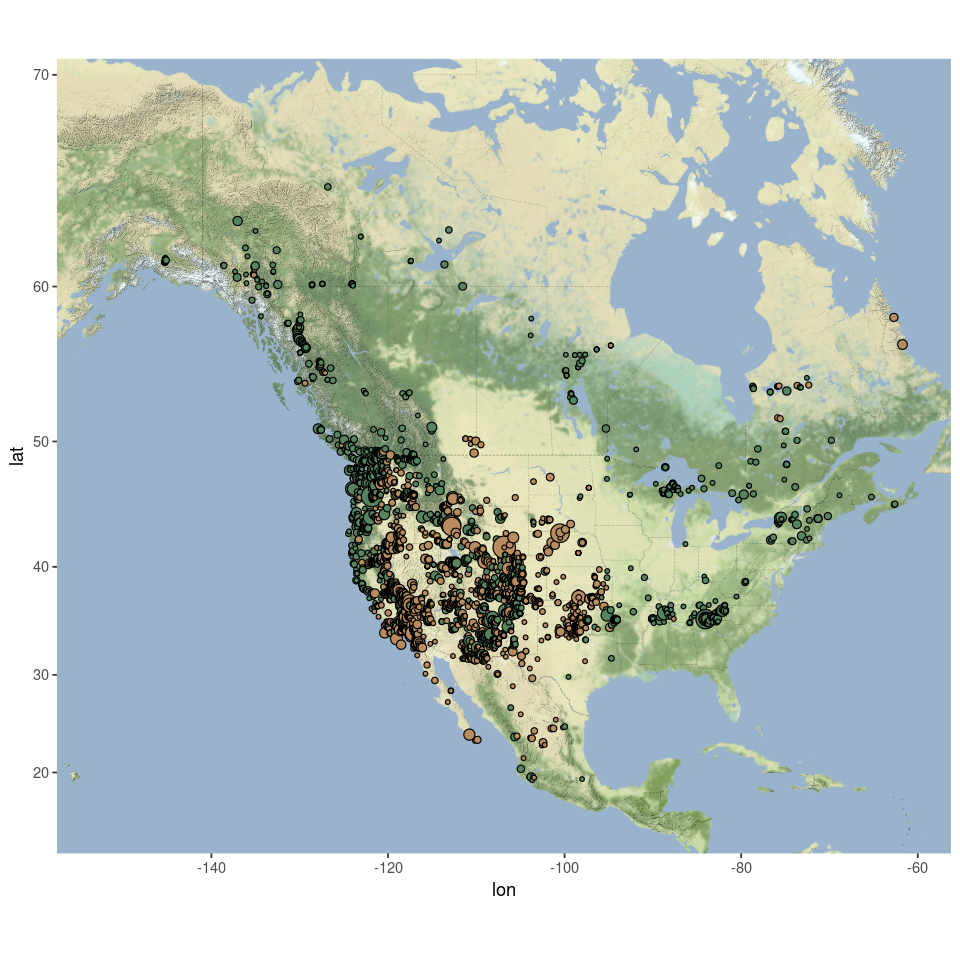

In [125]:
options(repr.plot.width=8,repr.plot.height=8)
ggmap(map) + 
  geom_point(data = t,aes(x=decimallongitude,y=decimallatitude,fill=hab_class,size=count),colour="black",pch=21) +
  scale_fill_manual(values=c('#56845F','#B88C5D')) +
  theme(legend.position="none")

Plot all samples w/ lat & lon, for "greater effect"

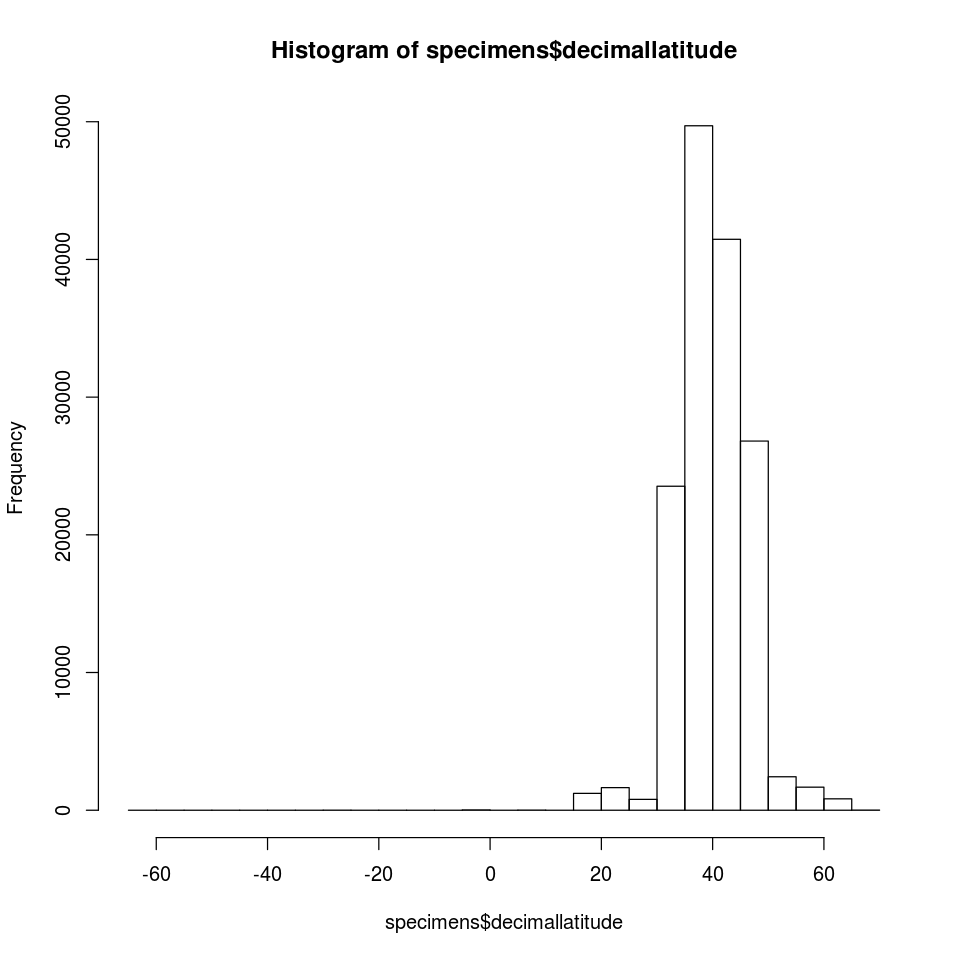

In [9]:
hist(specimens$decimallatitude)

In [11]:
library(ggmap)
specimens_plot = specimens %>% filter(decimallongitude < -50, decimallongitude > -150) %>% filter(decimallatitude > 0, decimallatitude < 80 )
bounds = make_bbox(lon=specimens_plot$decimallongitude,lat=specimens_plot$decimallatitude)
map = get_stamenmap(bounds, zoom = 5, maptype = "terrain-background",crop=FALSE)

90 tiles needed, this may take a while (try a smaller zoom).


In [12]:
forest = c(1,2,3,4,5,6,14)
open = c(7,8,9,10,11,12,13)
specimens_plot %<>% 
    mutate(hab_class = ifelse(NA_NALCMS_LC_30m_LAEA_mmu12_urb05 %in% forest,"forest","shrub/grassland")) %>% 
    group_by(decimallongitude,decimallatitude,hab_class) %>% summarize(count=n())
unique(specimens_plot$hab_class)

[1] "forest"          "shrub/grassland"

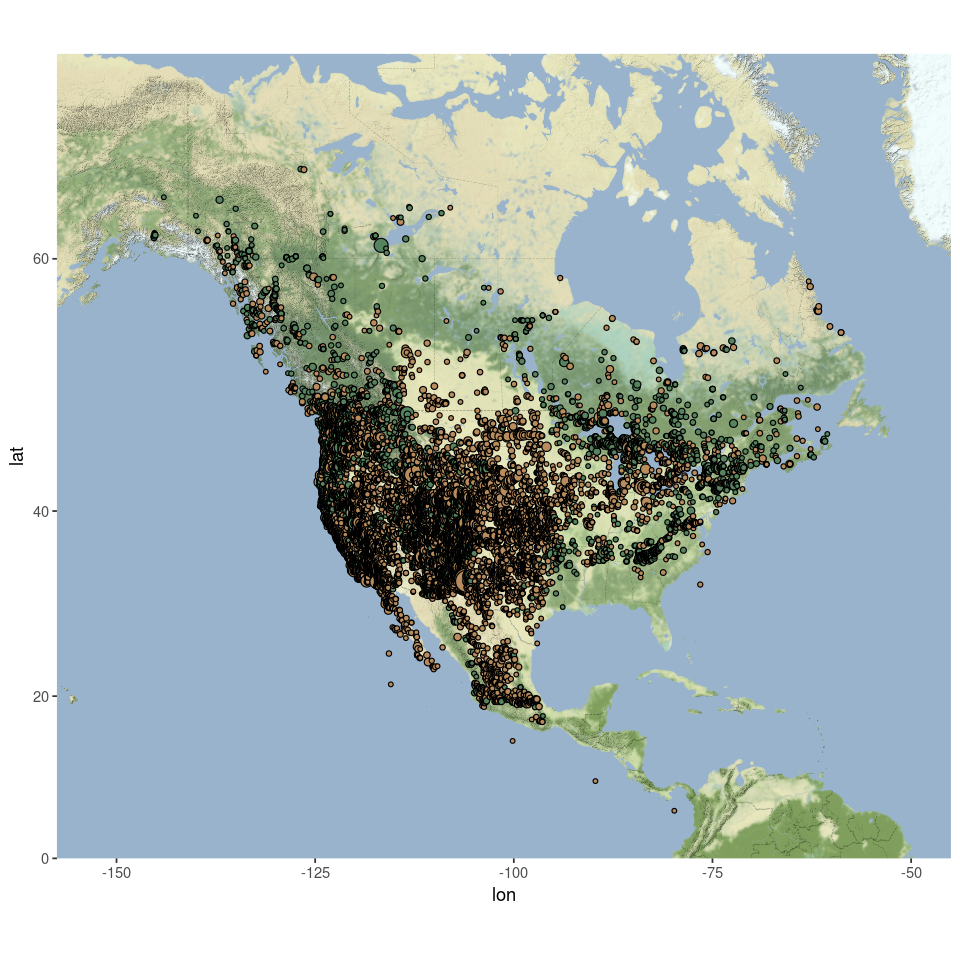

In [13]:
options(repr.plot.width=8,repr.plot.height=8)
ggmap(map) + 
  geom_point(data = specimens_plot,aes(x=decimallongitude,y=decimallatitude,fill=hab_class,size=count),colour="black",pch=21) +
  scale_fill_manual(values=c('#56845F','#B88C5D')) +
  theme(legend.position="none")

In [9]:
nrow(specimens_plot)

[1] 21552

# Scratch

In [8]:
specimens = read.delim("fulldata_processed_20181221.txt",sep="\t",header=TRUE)

In [10]:
nrow(specimens %>% distinct)

[1] 213048

In [15]:
specimens %>% filter(ids=="HSU:1007")

ids      scientificname         sex  stateprovince
1 HSU:1007 Peromyscus maniculatus male California   
2 HSU:1007 Peromyscus maniculatus NA   California   
  locality                    decimallongitude decimallatitude preparations
1 ARCATA, MAD RIVER           NA               NA              SSKU        
2 Clear Lake, Grouse Mountain NA               NA              skin | skull
  lifestage hastissue dynamicproperties                                   
1 NA        0         {measurements:160-78-20-15 };                       
2 NA        0         {measurements:TotalLength=181 Tail=83 HindFoot=19 };
  habitat year total tail foot ear weight body
1 NA      1969 160   78   20   15  NA     NA  
2 NA      1940 181   83   19   NA  NA     NA

In [14]:
writeable = specimens %>% filter(!is.na(decimallongitude)) %>% distinct
writeable$ROW = seq(1,nrow(writeable))
fwrite(writeable,file="fulldata_processed_20181221_coordinatesonly.txt",na="NA",sep="\t",row.names=FALSE,col.names=FALSE)

In [2]:
specimens = read.delim("fulldata_processed_20181221_coordinatesonly.txt",sep="\t",header=FALSE)

In [6]:
specimens %>% distinct %>% group_by(V1) %>% summarize(count=n()) %>% filter(count >=2) 

V1         count
1  MSB:300220  2   
2  MSB:300355  2   
3  MSB:300769  2   
4  MSB:300864  2   
5  MSB:301042  2   
6  MSB:301067  2   
7  MSB:301106  2   
8  MSB:301203  2   
9  MVZ:3       2   
10 MVZ:39      2   
11 MVZ:58      2   
12 MVZ:59      2   
13 MVZ:61162   2   
14 MVZ:75      2   
15 MVZ:8       2   
16 OMNH:13944  2   
17 OMNH:3316   2   
18 OMNH:7981   2   
19 OMNH:7984   2   
20 OMNH:7985   2   
21 OMNH:7989   2   
22 OMNH:7990   2   
23 OMNH:7991   2   
24 OMNH:7995   2   
25 PBDB:      20   
26 SBMNH:1086  2   
27 SBMNH:1355  2   
28 SBMNH:1356  2   
29 SBMNH:1452  2   
30 SBMNH:1506  2   
⋮  ⋮          ⋮    
44 SBMNH:1663 2    
45 SBMNH:1664 2    
46 SBMNH:1665 2    
47 SBMNH:1691 2    
48 SBMNH:1692 2    
49 SBMNH:1694 2    
50 SBMNH:1695 2    
51 SBMNH:1696 2    
52 SBMNH:1697 2    
53 SBMNH:1701 2    
54 SBMNH:1702 2    
55 SBMNH:1703 2    
56 SBMNH:1704 2    
57 SBMNH:1705 2    
58 SBMNH:1706 2    
59 SBMNH:1707 2    
60 SBMNH:1709 2    
61 SBMNH:1710 2    
62 SBMNH:1711 2    
63 SBMNH:1712 2    
64 SBMNH:1713 2    
65 SBMNH:1714 2    
66 SBMNH:1743 2    
67 SBMNH:2041 2    
68 SBMNH:2068 2    
69 SBMNH:2069 2    
70 SBMNH:2070 2    
71 SBMNH:2071 2    
72 SBMNH:2795 2    
73 SBMNH:2909 2

We'll do a fuzzy join based on lat/lon coordinates. For this to work, we need to get rid of NA values. It also takes a bit of time

In [7]:
specimens %>% filter(V1=="MVZ:3") %>% distinct

V1    V2                             V3     V4        
1 MVZ:3 Peromyscus maniculatus         female California
2 MVZ:3 Peromyscus maniculatus hylaeus male   Alaska    
  V5                                                       V6        V7      
1 Cannell Meadow, Sequoia National Forest                  -118.3682 35.83305
2 Windfall Harbor, Admiralty Island, Alexander Archipelago -134.2847 57.86556
  V8                 V9 V10
1 NA                 NA 0  
2 skull; skin, study NA 0  
  V11                                                                                                                             
1 sex=female ; hind foot with claw=20 cm; ear from notch=14 cm; weight=17 g; trap identifier=CN01-S80/80 ; trap type=Sherman trap;
2 sex=male;                                                                                                                       
  V12 V13  V14 V15 V16 V17 V18 V19
1 NA  2008 NA  NA  20  14  17  NA 
2 NA  1907 NA  NA  NA  NA  NA  NA

In [9]:
specimens = read.delim("fulldata_processed_20181221_coordinatesonly.txt",sep="\t",header=FALSE) %>% set_colnames(c('ids','scientificname','sex','stateprovince','locality','decimallongitude','decimallatitude','preparations','lifestage','hastissue','dynamicproperties','habitat','year','total','tail','foot','ear','weight','body'))
specimens = specimens %>% sample_n(100)
raster = read.delim("raster_data.csv",sep=",",header=TRUE) %>% dplyr::select(-X)
daymet = read.delim("combined_daymet.txt",sep="\t",header=TRUE) %>% distinct() %>% mutate_at(.vars=vars(lon,lat),.funs=funs(round(.,4)))

test = geo_left_join(specimens,daymet %>% rename("decimallatitude"="lat","decimallongitude"="lon"),unit="km",max_dist = 0.5)
test %<>% rename("decimallongitude"="decimallongitude.x","decimallatitude"="decimallatitude.x","decimallongitude.DAYMET"="decimallongitude.y","decimallatitude.DAYMET"="decimallatitude.y")
test = geo_left_join(test,raster,unit="km",max_dist = 0.5)
test %<>% rename("decimallongitude"="decimallongitude.x","decimallatitude"="decimallatitude.x","decimallongitude.RASTER"="decimallongitude.y","decimallatitude.RASTER"="decimallatitude.y")


Joining by: c("decimallongitude", "decimallatitude")
Joining by: c("decimallongitude", "decimallatitude")


In [10]:
r = list(.vars = lst('scientificname','sex','stateprovince','locality','decimallongitude','decimallatitude','preparations','lifestage','hastissue','dynamicproperties','habitat','year','total','tail','foot','ear','weight','body','decimallatitude.DAYMET','decimallongitude.DAYMET','elevation','tile','mean_annual_temp','mean_july_temp','mean_january_temp','mean_prec','mean_rad','ID','NA_NALCMS_LC_30m_LAEA_mmu12_urb05','decimallongitude.RASTER','decimallatitude.RASTER'),
     .funs = lst(unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,Mode,mean,mean)) %>% 
  pmap(~ test %>% group_by(ids) %>% summarise_at(.x, .y)) %>% 
  reduce(inner_join, by = "ids")

In [11]:
nrow(r)

[1] 100

In [81]:
test %>% filter(ids=="SBMNH:1662")

ids        scientificname                sex stateprovince
1  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
2  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
3  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
4  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
5  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
6  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
7  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
8  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
9  SBMNH:1662 Peromyscus maniculatus elusus NA  California   
10 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
11 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
12 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
13 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
14 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
15 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
16 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
17 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
18 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
19 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
20 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
21 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
22 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
23 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
24 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
25 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
26 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
27 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
28 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
29 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
30 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
31 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
32 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
33 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
34 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
35 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
36 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
   locality             decimallongitude.x decimallatitude.x preparations
1  Santa Barbara Island -119.0353          33.4756           NA          
2  Santa Barbara Island -119.0353          33.4756           NA          
3  Santa Barbara Island -119.0353          33.4756           NA          
4  Santa Barbara Island -119.0353          33.4756           NA          
5  Santa Barbara Island -119.0353          33.4756           NA          
6  Santa Barbara Island -119.0353          33.4756           NA          
7  Santa Barbara Island -119.0353          33.4756           NA          
8  Santa Barbara Island -119.0353          33.4756           NA          
9  Santa Barbara Island -119.0353          33.4756           NA          
10 Santa Barbara Island -119.0353          33.4756           NA          
11 Santa Barbara Island -119.0353          33.4756           NA          
12 Santa Barbara Island -119.0353          33.4756           NA          
13 Santa Barbara Island -119.0353          33.4756           NA          
14 Santa Barbara Island -119.0353          33.4756           NA          
15 Santa Barbara Island -119.0353          33.4756           NA          
16 Santa Barbara Island -119.0353          33.4756           NA          
17 Santa Barbara Island -119.0353          33.4756           NA          
18 Santa Barbara Island -119.0353          33.4756           NA          
19 Santa Barbara Island -119.0353          33.4756           NA          
20 Santa Barbara Island -119.0353          33.4756           NA          
21 Santa Barbara Island -119.0353          33.4756           NA          
22 Santa Barbara Island -119.0353          33.4756           NA          
23 Sant

In [82]:
r %>% filter(ids=="SBMNH:1662")

ids        scientificname                sex stateprovince
1 SBMNH:1662 Peromyscus maniculatus elusus NA  California   
  locality             decimallongitude.x decimallatitude.x preparations
1 Santa Barbara Island -119.0353          33.4756           NA          
  lifestage hastissue ⋯ mean_annual_temp mean_july_temp mean_january_temp
1 NA        0         ⋯ 14.92592         17.38502       12.57674         
  mean_prec mean_rad X       ID NA_NALCMS_LC_30m_LAEA_mmu12_urb05
1 0.9530711 343.997  12712.5 1  9                                
  decimallongitude.RASTER decimallatitude.RASTER
1 -119.035                33.47605

V1        V2                     V3     V4      
1 MSB:76577 Peromyscus maniculatus female Colorado
2 MSB:76581 Peromyscus maniculatus female Colorado
3 MSB:78272 Peromyscus maniculatus female Colorado
4 MSB:78274 Peromyscus maniculatus female Colorado
5 MSB:78275 Peromyscus maniculatus male   Colorado
6 MSB:78276 Peromyscus maniculatus female Colorado
  V5                                                          V6        V7     
1 DOUGLAS PASS.  39D40'N, 108D50'W.  LINE TD; 39D40'N108D50'W -108.8025 39.5975
2 DOUGLAS PASS 39D40'N 108D50'W LINE DTT; 39D40'N108D50'W     -108.8025 39.5975
3 26MI N BY RD. DE BOQUE, CARR CREEK                          -108.5005 39.5763
4 26MI N BY RD. DE BOQUE, CARR CREEK                          -108.5005 39.5763
5 26MI N BY RD. DE BOQUE, CARR CREEK                          -108.5005 39.5763
6 26MI N BY RD. DE BOQUE, CARR CREEK                          -108.5005 39.5763
  V8                                                                                              
1 liver (frozen); heart, kidney (frozen); spleen (frozen); whole organism (alcohol); lung (frozen)
2 liver (frozen); heart, kidney (frozen); spleen (frozen); whole organism (alcohol); lung (frozen)
3 liver (frozen); heart, kidney (frozen); spleen (frozen); whole organism (alcohol); lung (frozen)
4 liver (frozen); whole organism (alcohol); heart, kidney (frozen)                                
5 liver (frozen); heart, kidney (frozen); spleen (frozen); whole organism (alcohol); lung (frozen)
6 liver (frozen); whole organism (alcohol); lung (frozen); heart, kidney (frozen)                 
  V9 V10 ⋯ V23   V24      V25      V26       V27      V28     V29 V30 V31      
1 NA 1   ⋯ 11556 6.888290 19.87565 -4.424818 1.459832 398.897 1   1   -108.8025
2 NA 1   ⋯ 11556 6.888290 19.87565 -4.424818 1.459832 398.897 1   1   -108.8025
3 NA 1   ⋯ 11556 6.423884 19.20499 -4.510926 1.774547 400.922 1   1   -108.5005
4 NA 1   ⋯ 11556 6.423884 19.20499 -4.510926 1.774547 400.922 1   1   -108.5005
5 NA 1   ⋯ 11556 6.423884 19.20499 -4.510926 1.774547 400.922 1   1   -108.5005
6 NA 1   ⋯ 11556 6.423884 19.20499 -4.510926 1.774547 400.922 1   1   -108.5005
  V32     
1 39.59748
2 39.59748
3 39.57632
4 39.57632
5 39.57632
6 39.57632

In [ ]:
t = read.delim("smallfiles/specimens_env_fh",header=FALSE,sep=" ") %>% set_colnames(c('ids','scientificname','sex','stateprovince','locality','decimallongitude','decimallatitude','preparations','lifestage','hastissue','dynamicproperties','habitat','year','total','tail','foot','ear','weight','body','decimallatitude.DAYMET','decimallongitude.DAYMET','elevation','tile','mean_annual_temp','mean_july_temp','mean_january_temp','mean_prec','mean_rad','ID','NA_NALCMS_LC_30m_LAEA_mmu12_urb05','decimallongitude.RASTER','decimallatitude.RASTER'))
r = list(.vars = lst('scientificname','sex','stateprovince','locality','decimallongitude','decimallatitude','preparations','lifestage','hastissue','dynamicproperties','habitat','year','total','tail','foot','ear','weight','body','decimallatitude.DAYMET','decimallongitude.DAYMET','elevation','tile','mean_annual_temp','mean_july_temp','mean_january_temp','mean_prec','mean_rad','ID','NA_NALCMS_LC_30m_LAEA_mmu12_urb05','decimallongitude.RASTER','decimallatitude.RASTER'),
     .funs = lst(unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,unique,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,Mode,mean,mean)) %>% 
  pmap(~ t %>% group_by(ids) %>% summarise_at(.x, .y)) %>% 
  reduce(inner_join, by = "ids")

In [10]:
t = read.delim("smallfiles/specimens_input_cs",sep="\t",header=FALSE)
t %>% group_by(V1) %>% summarize(count=n()) %>% filter(count>=2) #%>% pull(V1)

V1    count
1 PBDB: 20

In [ ]:
forest <- c(1,2,3,4,5,6,14)

In [15]:
head(raster)
sample_n(specimens,5)

X ID NA_NALCMS_LC_30m_LAEA_mmu12_urb05 decimallongitude decimallatitude
1 1 1   5                                -86.85657        46.02127       
2 2 1   5                                -87.21667        46.46398       
3 3 1   5                                -88.98650        46.29683       
4 4 1   5                                -87.20081        46.46527       
5 5 1   5                                -88.98198        46.29736       
6 6 1  14                                -88.98655        46.29759

ids         scientificname                  sex    stateprovince
104153 CRCM:05-374 Peromyscus maniculatus          female Idaho        
164669 MSB:82720   Peromyscus maniculatus          male   North Dakota 
37955  TTU:15159   Peromyscus maniculatus luteus   male   Texas        
136361 UMMZ:136804 Peromyscus maniculatus blandus  male   New Mexico   
98922  USNM:94962  Peromyscus maniculatus gambelii male   California   
       locality                                 decimallongitude
104153 Bear Creek Campground, Custer Co., Idaho        NA       
164669 FOXHOLM; 48 24N 101 35W                  -101.3600       
37955  PANTEX RESEARCH FARM                     -101.6960       
136361 SALINAS                                  -106.0597       
98922  Mount Shasta, Upper Mud Creek                   NA       
       decimallatitude preparations             lifestage hastissue
104153     NA          skin (round)             NA        0        
164669 48.230          whole organism (alcohol) NA        0        
37955  35.185          AL | alcoholic           NA        1        
136361 33.235          skin                     25 WEEKS  0        
98922      NA          Skin; Skull              NA        0        
       dynamicproperties                                                               
104153 {ear length:20.0, hind foot length:21.0, tail length:75.0, total length:176.0 };
164669 sex=male;                                                                       
37955  NA                                                                              
136361 NA                                                                              
98922  NA                                                                              
       habitat year total tail foot ear weight body
104153 NA      1950 176   75   21   20  NA     NA  
164669 NA      1995  NA   NA   NA   NA  NA     NA  
37955  NA      1972  NA   NA   NA   NA  NA     NA  
136361 NA      1940  NA   NA   NA   NA  NA     NA  
98922  NA      1898  NA   NA   NA   NA  NA     NA

In [143]:
full = left_join(specimens,raster,by=c("decimallatitude"="lat","decimallongitude"="lon"))

Which samples didn't successfully retrieve daymet data?. Some won't have lat/lon, so let's make sure to ignore those

In [141]:
full %>% 
    filter(!is.na(decimallongitude)) %>% 
    filter(is.na(tile)) %>%
    filter(!is.na(total)) %>%
    count()

n  
1 369

Only 369 samples with length data are "lost", which is ok